In this project, I will be working with the BBC News Classification (https://www.kaggle.com/c/learn-ai-bbc) with the primary goal of predicting news article categories via matrix factorization. The project will be available in its entirety on GitHub (https://github.com/giosofteng/bbcnc).

Let us begin by importing and cleaning our data (“BBC News Train.csv”). Let us make all text lowercase, remove all punctuation, get rid of words like “at”, “the”, etc. (stop words) and convert the words we will be left with to their base forms (lemmatize them). Since we are dealing with a NLP problem, let us rely on a popular and battle-tested library called NLTK.

In [76]:
import string
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
# download necessary NLTK resources
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()
stopwords = set(stopwords.words('english'))

def clean_text(text):
    # make text lowercase
    text = text.lower()
    # remove punctuation
    text = ''.join([char for char in text if char not in string.punctuation])
    # tokenize text
    words = nltk.word_tokenize(text)
    # remove stop words
    words = [word for word in words if word not in stopwords]
    # lemmatize words
    words = [lemmatizer.lemmatize(word) for word in words]
    # convert words back into sentances
    return ' '.join(words)

# load training data
data_train = pd.read_csv('BBC News Train.csv')
# clean 'Text' column
data_train['Text'] = data_train['Text'].apply(clean_text)
print(data_train.head())

# do the same with test data
data_test = pd.read_csv('BBC News Test.csv')
data_test['Text'] = data_test['Text'].apply(clean_text)

[nltk_data] Downloading package punkt to /Users/george/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/george/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/george/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/george/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


   ArticleId                                               Text  Category
0       1833  worldcom exboss launch defence lawyer defendin...  business
1        154  german business confidence slide german busine...  business
2       1101  bbc poll indicates economic gloom citizen majo...  business
3       1976  lifestyle governs mobile choice faster better ...      tech
4        917  enron boss 168m payout eighteen former enron d...  business


With our data clean and in proper format, let us do some basic EDA to get a better overview of what we are working with.

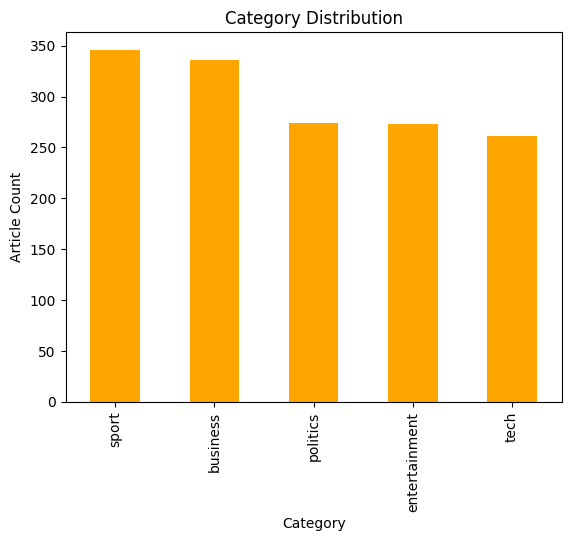

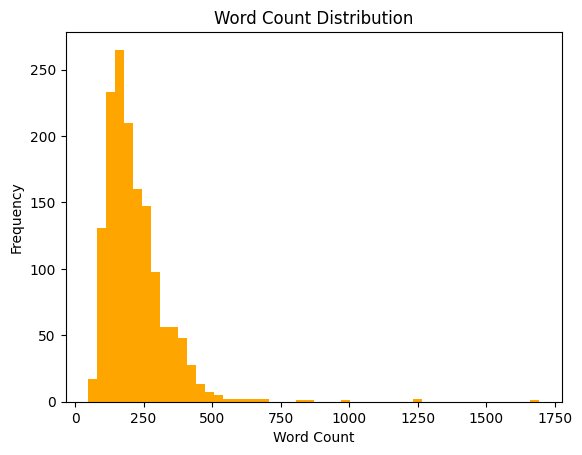

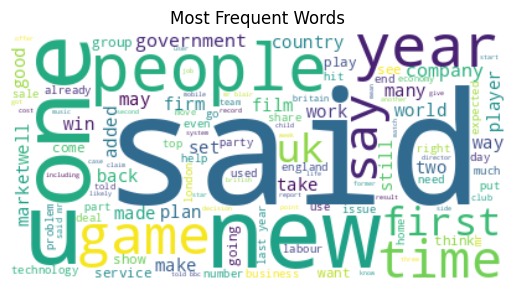

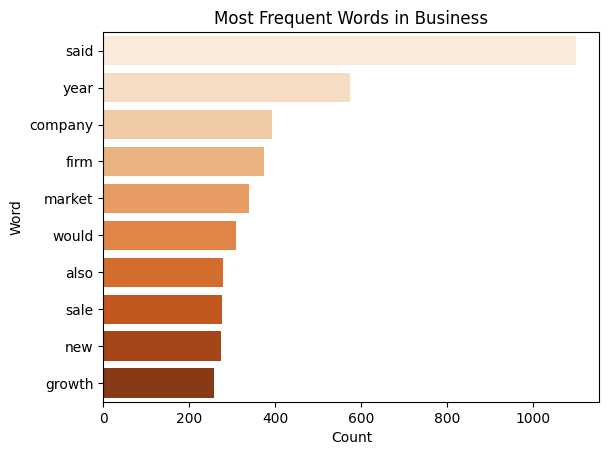

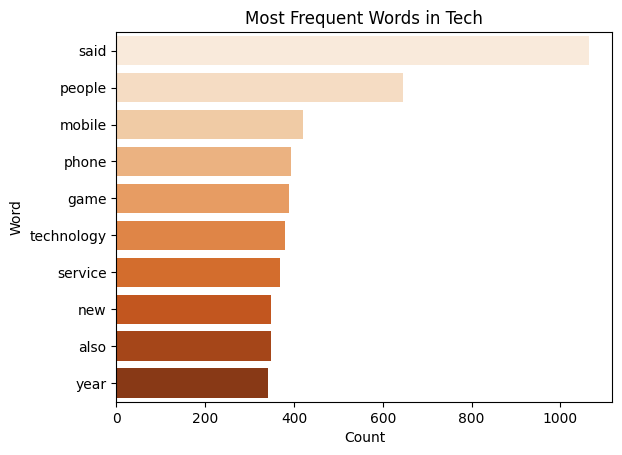

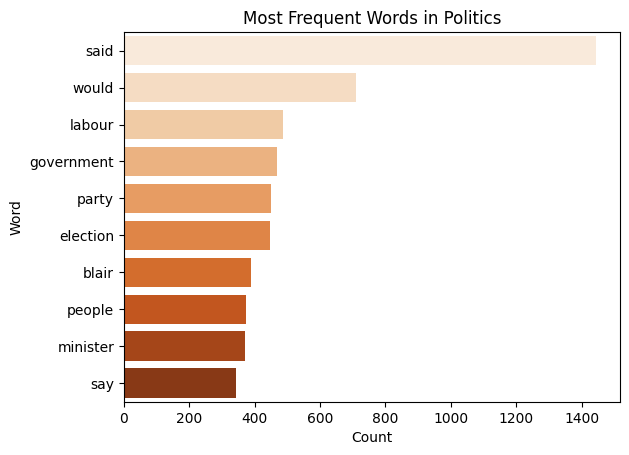

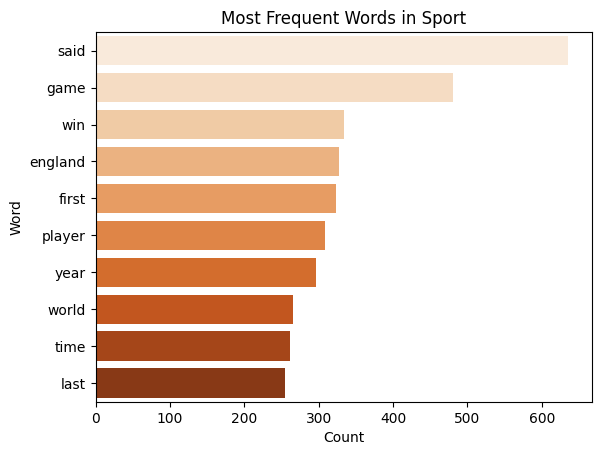

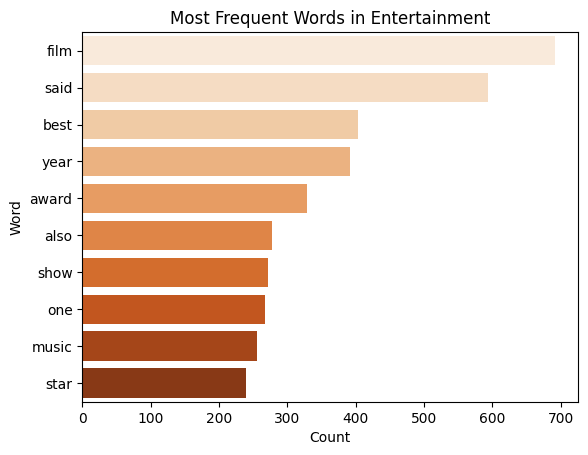

In [77]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# display a bar chart of each category's article count
data_train['Category'].value_counts().plot(kind='bar', color='orange')
plt.title('Category Distribution')
plt.xlabel('Category')
plt.ylabel('Article Count')
plt.show()


# display a histogram of articles' word counts
data_train['TextLength'] = data_train['Text'].apply(lambda x: len(x.split()))
data_train['TextLength'].plot(kind='hist', bins=50, color='orange')
plt.title('Word Count Distribution')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()


# display a word cloud of most frequent words
wordcloud = WordCloud(background_color='white').generate(' '.join(data_train['Text']))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Frequent Words')
plt.show()


# display bar plots of each category's top 10 most frequent words
def get_top_10_words(text):
    words = ' '.join(text).split()
    words = [word for word in words if word not in stopwords and len(word) > 2]
    return Counter(words).most_common(10)

for category in data_train['Category'].unique():
    text = data_train[data_train['Category'] == category]['Text']
    words, counts = zip(*get_top_10_words(text))
    sns.barplot(x=list(counts), y=list(words), hue=list(words), palette='Oranges', dodge=False, legend=False)
    plt.title(f'Most Frequent Words in {category.capitalize()}')
    plt.xlabel('Count')
    plt.ylabel('Word')
    plt.show()

With EDA behind us, let us begin the feature extraction process. Here, we will re-interpret our text data as numbers that a machine learning model can process. There are several methods we can use, but the most common one (and the one that I have chosen) is TF-IDF (Term Frequency-Inverse Document Frequency). This method involves measuring the importance of words in a document.

In [78]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
# fit and transform text data
X_train_tfidf = vectorizer.fit_transform(data_train['Text'])
X_test_tfidf = vectorizer.transform(data_test['Text'])

# display TF-IDF matrix's shape
print(f'TF-IDF matrix shape: {X_train_tfidf.shape}')
# display transformed data
print(X_train_tfidf[0])

TF-IDF matrix shape: (1490, 5000)
<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 107 stored elements and shape (1, 5000)>
  Coords	Values
  (0, 4954)	0.5325209869504669
  (0, 2620)	0.03958124666571761
  (0, 1293)	0.043072019834677684
  (0, 2626)	0.1346532675126353
  (0, 1297)	0.05285148207403036
  (0, 897)	0.08789549336417264
  (0, 1530)	0.37123462550011815
  (0, 546)	0.05640476793327559
  (0, 1928)	0.18549683293966723
  (0, 874)	0.1085462723899813
  (0, 769)	0.032862062095547824
  (0, 1014)	0.05047524185051944
  (0, 4937)	0.11681075873930184
  (0, 1138)	0.2399750803878017
  (0, 2408)	0.057029452736788444
  (0, 211)	0.3762364185275115
  (0, 1392)	0.03030681789166472
  (0, 3414)	0.09914017825377283
  (0, 4503)	0.04896378817037538
  (0, 2016)	0.0371641805674489
  (0, 71)	0.07670888386750643
  (0, 4860)	0.04323957057530847
  (0, 2643)	0.03804374070114173
  (0, 976)	0.05422740870689284
  (0, 1852)	0.052843751591227124
  :	:
  (0, 4512)	0.052026710527131814
  (0, 2210)	0.0299

Now then, let us finally move on to building our model. To start with, we will not be including text from test data when training our model. After all, it already has a set purpose of simulating unseen data. Showing it to our model in advance defeats the purpose. Furthermore, it could lead to a thing called “data leakage”, making our model seem unrealistically accurate.

From matrix factorization techniques, let us use NMF (Non-Negative Matrix Factorization)—a popular choice for working with text data.

Train accuracy: 0.24563758389261744


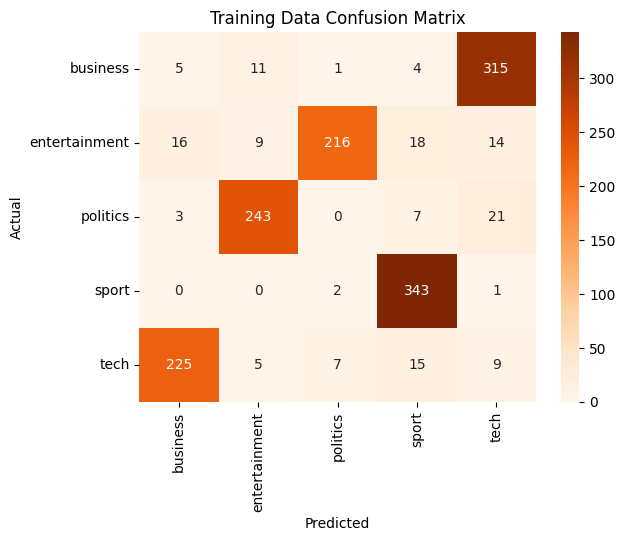

Test accuracy (according to Kaggle): 0.23945


In [79]:
from sklearn.decomposition import NMF
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix

nmf_model = NMF(n_components=5, random_state=42)
nmf_model.fit(X_train_tfidf)

# transform data to topic space
W_train = nmf_model.transform(X_train_tfidf)
W_test = nmf_model.transform(X_test_tfidf)

# encode labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(data_train['Category'])

# store predicted labels
train_preds = W_train.argmax(axis=1)
test_preds = W_test.argmax(axis=1)

# convert them back to category names
train_pred_labels = label_encoder.inverse_transform(train_preds)
test_pred_labels = label_encoder.inverse_transform(test_preds)

# display accuracy scores
train_accuracy = accuracy_score(data_train['Category'], train_pred_labels)
print(f'Train accuracy: {train_accuracy}')

# display confusion matrix
conf_mat_train = confusion_matrix(data_train['Category'], train_pred_labels)
sns.heatmap(conf_mat_train, annot=True, fmt="d", cmap="Oranges", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Training Data Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

# create Kaggle submission
submission = pd.DataFrame({
    'ArticleId': data_test['ArticleId'],
    'Category': test_pred_labels
})
submission.to_csv('submission.csv', index=False)
print('Test accuracy (according to Kaggle): 0.23945')

So, it seems that our initial model yields training accuracy of ~25%  and test accuracy of ~24%. Plenty of room for improvement!

Train accuracy: 0.4463087248322148


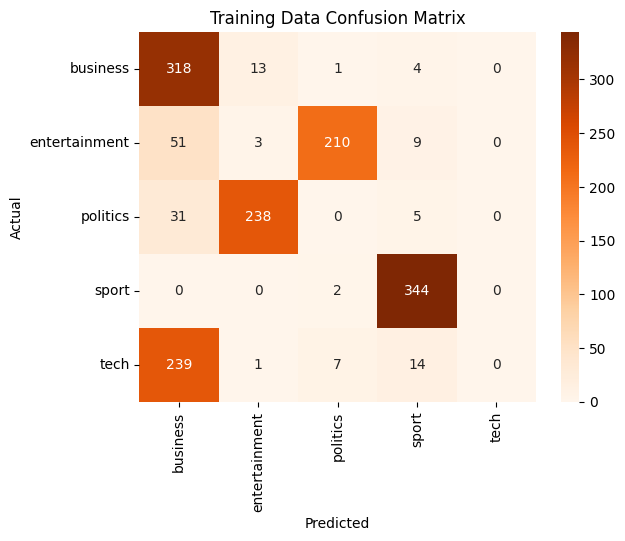

Test accuracy (according to Kaggle): 0.44625


In [80]:
# include bi-grams
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1,2))
X_train_tfidf = vectorizer.fit_transform(data_train['Text'])
X_test_tfidf = vectorizer.transform(data_test['Text'])

# set topic count to 4; choose more optimal solver
nmf_model = NMF(n_components=4, random_state=42, solver='mu')
nmf_model.fit(X_train_tfidf)

# rest of the code remains unchanged
W_train = nmf_model.transform(X_train_tfidf)
W_test = nmf_model.transform(X_test_tfidf)

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(data_train['Category'])

train_preds = W_train.argmax(axis=1)
test_preds = W_test.argmax(axis=1)

train_pred_labels = label_encoder.inverse_transform(train_preds)
test_pred_labels = label_encoder.inverse_transform(test_preds)

train_accuracy = accuracy_score(data_train['Category'], train_pred_labels)
print(f'Train accuracy: {train_accuracy}')

conf_mat_train = confusion_matrix(data_train['Category'], train_pred_labels)
sns.heatmap(conf_mat_train, annot=True, fmt="d", cmap="Oranges", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Training Data Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

submission = pd.DataFrame({
    'ArticleId': data_test['ArticleId'],
    'Category': test_pred_labels
})
submission.to_csv('submission.csv', index=False)
print('Test accuracy (according to Kaggle): 0.44625')

So, by including bi-grams, choosing an optimal topic count of 4, and using a more optimal solver, we managed to increase our accuracy to ~45%. I also tried setting different feature counts, including more n-grams, and using LDA instead of NMF, but none of these yielded better accuracy.

Let us now implement a supervised approach and compare results.

Train accuracy: 0.9979865771812081


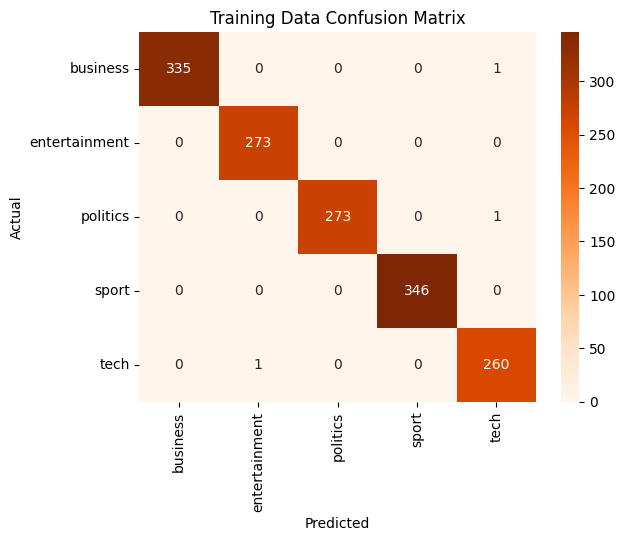

Test accuracy (according to Kaggle): 0.98231


In [81]:
from sklearn.linear_model import LogisticRegression

# train Logistic Regression model
log_reg_model = LogisticRegression(max_iter=1000)
log_reg_model.fit(X_train_tfidf, data_train['Category'])

train_pred_labels = log_reg_model.predict(X_train_tfidf)
test_pred_labels = log_reg_model.predict(X_test_tfidf)

train_accuracy = accuracy_score(data_train['Category'], train_pred_labels)
print(f'Train accuracy: {train_accuracy}')

conf_mat_train = confusion_matrix(data_train['Category'], train_pred_labels)
sns.heatmap(conf_mat_train, annot=True, fmt="d", cmap="Oranges", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Training Data Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

submission = pd.DataFrame({
    'ArticleId': data_test['ArticleId'],
    'Category': test_pred_labels
})
submission.to_csv('submission.csv', index=False)
print('Test accuracy (according to Kaggle): 0.98231')

So, by implementing a trivial supervised (Logistic Regression) model, we managed to increase our test accuracy to ~98%!

Let us also check how the supervised approach performs with limited training data (10%, 20%, and 50%).

In [82]:
from sklearn.model_selection import train_test_split

def train_percent(X, y, percent):
    # sample specified percent of data
    X_sample, _, y_sample, _ = train_test_split(X, y, train_size=percent, random_state=42)
    
    log_reg_model = LogisticRegression(max_iter=1000)
    log_reg_model.fit(X_sample, y_sample)
    
    train_pred_labels = log_reg_model.predict(X)
    test_pred_labels = log_reg_model.predict(X_test_tfidf)
    
    train_accuracy = accuracy_score(y, train_pred_labels)
    print(f'Train accuracy with {int(percent * 100)}% of labels: {train_accuracy}')
    
    return test_pred_labels

# train with 10% of labels
test_pred_labels_10 = train_percent(X_train_tfidf, data_train['Category'], 0.1)
submission_10 = pd.DataFrame({
    'ArticleId': data_test['ArticleId'],
    'Category': test_pred_labels_10
})
submission_10.to_csv('submission_10.csv', index=False)
print('Test accuracy with 10% of labels (according to Kaggle): 0.85306')

# train with 20% of labels
test_pred_labels_20 = train_percent(X_train_tfidf, data_train['Category'], 0.2)
submission_20 = pd.DataFrame({
    'ArticleId': data_test['ArticleId'],
    'Category': test_pred_labels_20
})
submission_20.to_csv('submission_20.csv', index=False)
print('Test accuracy with 20% of labels (according to Kaggle): 0.95782')

# train with 50% of labels
test_pred_labels_50 = train_percent(X_train_tfidf, data_train['Category'], 0.5)
submission_50 = pd.DataFrame({
    'ArticleId': data_test['ArticleId'],
    'Category': test_pred_labels_50
})
submission_50.to_csv('submission_50.csv', index=False)
print('Test accuracy with 50% of labels (according to Kaggle): 0.97551')

Train accuracy with 10% of labels: 0.8651006711409396
Test accuracy with 10% of labels (according to Kaggle): 0.85306
Train accuracy with 20% of labels: 0.9503355704697987
Test accuracy with 20% of labels (according to Kaggle): 0.95782
Train accuracy with 50% of labels: 0.9865771812080537
Test accuracy with 50% of labels (according to Kaggle): 0.97551


It seems that our supervised method performs quite well even with small amounts of data! We achieved a train/test accuracy of ~87/85% at 10% of labels, ~95/96% at 20% of labels, and ~99/98% at 50% of labels. Great results all around! Our supervised approach performs very well even with limited data and does not suffer from overfitting at all. For this problem, it seems to be a far superior approach!

Kaggle results:
![Alt Text](./kaggle_results.png)